# Applied Data Science @ Columbia

## Project 1: What made you happy today?


### Project Description
- Project title: Childfree Life - What Brings Happiness to Married Couples Without Children in America?
- Author: Tien Nguyen - tn2510
- Project Summary: 
In contemporary America, the choice to lead a childfree life is increasingly prevalent. This project delves into the intricacies of happiness among married couples who have consciously opted out of parenthood. Through comprehensive research and interviews, several key inquiries were addressed to illuminate the facets of their contentment and fulfillment.

+ Key Questions Explored:

1. Do they ever want children? Do they regret not having a child? Why do they not want children?

Understanding the motivations behind choosing a childfree lifestyle is fundamental. By delving into their desires, regrets, and reasons for opting out of parenthood, we unravel the intricate tapestry of their decision-making process.

2. What personal achievements or career milestones are most commonly associated with happiness among married women without children?

Exploring the professional and personal accomplishments that contribute to their sense of fulfillment provides insights into alternative sources of joy and satisfaction beyond traditional family dynamics.

3. How do leisure activities and hobbies contribute to their sense of joy and fulfillment?

Investigating the role of leisure pursuits and hobbies sheds light on the diverse avenues through which individuals cultivate happiness and enrich their lives outside the realm of parenting.

### Import Necessary Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as p
import warnings 
warnings.filterwarnings('ignore')


import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# download nltk corpus (first time only)
# nltk.download('all')
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.parsing.preprocessing import remove_stopwords, strip_numeric, strip_punctuation, strip_short
from wordcloud import WordCloud

import spacy

[nltk_data] Downloading package punkt to /Users/stephanie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stephanie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stephanie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import Datasets

1. Main Datasets

In [2]:
cleaned_hm = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/cleaned_hm.csv")
# Show the first 5 rows of this dataframe
cleaned_hm.head() 

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [3]:
demographic = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/demographic.csv")
# Show the first 5 rows of the dataframe
demographic.head() 

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


2. Topic Datasets

In [4]:
entertainment = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/entertainment-dict.csv")
exercise = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/exercise-dict.csv")
family = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/family-dict.csv")
food = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/food-dict.csv")
people = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/people-dict.csv")
pets = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/pets-dict.csv")
school = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/school-dict.csv")
shopping = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/shopping-dict.csv")
work = pd.read_csv("/Users/stephanie/ADS/Projects_StarterCodes/Project1-RNotebook/data/work-dict.csv")

### Data Cleaning and Preprocessing

1. Clean the Demographic Dataframe

In [5]:
# Ages are represented inconsistently, with some being integers and others including decimals. 
# To ensure uniformity, convert the age to float --> integer & remove any decimals. 
def convert_age_to_integer(age):
    try:
        age = int(float(age))
    except ValueError:
        # If conversion fails, return None
        return None
    return age

demographic['age'] = demographic['age'].apply(convert_age_to_integer)

# Remove rows with None in Age column
demographic = demographic.dropna(subset=['age'])

In [6]:
# Filter the Demographic DataFrame to keep only rows with 
#'marital' as 'married', 'country' as 'USA', and 'parenthood' as 'n'
demographic = demographic[(demographic['marital'] == 'married') & (demographic['country'] == 'USA') & (demographic['parenthood'] == 'n')]

2. Clean the Cleaned_hm Dataframe

In [7]:
#Remove unnecessary columns in cleaned_hm
cleaned_hm = cleaned_hm.drop(columns=['original_hm', 'modified', 'num_sentence', 'ground_truth_category'])

In [10]:
# Merge Cleaned_hm and Demographic DataFrames
df_cd = pd.merge(cleaned_hm,demographic, on ="wid")

In [11]:
df_cd.head(5)

,hmid,wid,reflection_period,cleaned_hm,predicted_category,age,country,gender,marital,parenthood
0,27699,156,24h,I napped with my husband on the bed this after...,affection,47.0,USA,f,married,n
1,27899,156,24h,My mother-in-law offered me money so I could b...,affection,47.0,USA,f,married,n
2,28099,156,24h,"I've been thinking about dreams, life and deat...",enjoy_the_moment,47.0,USA,f,married,n
3,37561,156,24h,"I've watched the movie ""Moana"" and it made me ...",enjoy_the_moment,47.0,USA,f,married,n
4,38560,156,24h,I found a new way to introduced my main male c...,achievement,47.0,USA,f,married,n


3. View Data Distribution

In [17]:
gender_distribution = df_cd['gender'].value_counts()
print(gender_distribution)

gender
m    4458
f    3759
o      27
Name: count, dtype: int64


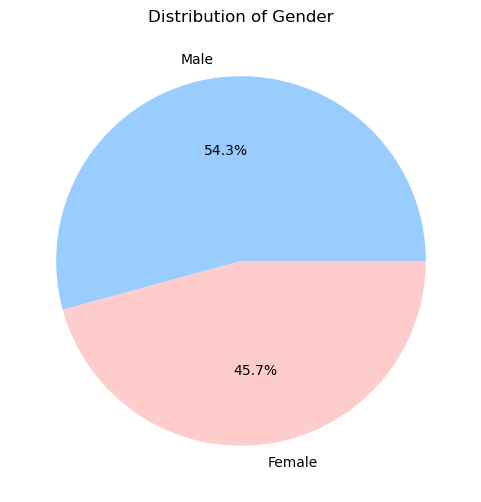

In [26]:
#Filter out entries with gender 'o'
df_cd = df_cd[df_cd['gender'] != 'o']

# Calculate the distribution of genders after filtering
gender_distribution = df_cd['gender'].value_counts()

gender_labels = {'f': 'Female', 'm': 'Male'}

# Plotting the distribution as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_distribution, labels=gender_distribution.index.map(gender_labels), autopct='%1.1f%%', colors=['#99ccff', '#ffcccc'])

# Adding a title
plt.title('Distribution of Gender')

# Displaying the plot
plt.show()

In [6]:
## Identify the age group that responded the most
age_counts = demographic['age'].value_counts().sort_values(ascending=False).head(15)
print("\nNumber of people in each age group:")
print(age_counts)


Number of people in each age group:
age
29.0    73
26.0    71
30.0    65
27.0    65
25.0    62
31.0    61
32.0    55
33.0    54
28.0    43
24.0    41
34.0    36
36.0    34
35.0    28
23.0    25
38.0    22
Name: count, dtype: int64
